# Encoding the Audio

In [1]:
import sys 
import os 
import pickle 
import numpy as np
import spacy
import seaborn as sns
import matplotlib as plt 
import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath("../lingpred_new/"))
from plotting import colours
from encoding_analysis import regress_out_one, make_arbitrary_static_vectors, brainscore_no_coef
from utils import get_words_onsets_offsets, get_indices_per_task, make_y_matrix_per_run


In [2]:
dataset  = 'Goldstein'

# Let's get X matrices for arbitrary vectors:
words_df = get_words_onsets_offsets(dataset)
X        = make_arbitrary_static_vectors(words_df, dim=300)

# make an X matrix with residualised vectors
X_residualised = regress_out_one(X)
X.shape, X_residualised.shape


((5136, 300), (5135, 300))

In [53]:
# load the acoustic model:
with open('/Users/ines/research/Lingpred/audio/Goldstein/acoustic_model_8_mels_averaged_per_word.pkl', 'rb') as f:
    acoustics = pickle.load(f)

acoustics.shape

(5136, 9)

In [4]:
'''
# Compute the indices for making the y matrix
# -------------------------------------------
# This is already saved under audio/Goldstein/indices_all_tasks.pkl
# No need to run this again, as this would take  approx. 10 min

indices = get_indices_per_task(dataset)
indices.shape

dir_path = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'indices_all_tasks.pkl'
path      = dir_path + file_name

print(path)
f = open(path,"wb")
pickle.dump(indices, f)
f.close()

'''

# load the indices:
with open('/Users/ines/research/Lingpred/audio/Goldstein/indices_all_tasks.pkl', 'rb') as f:
    indices = pickle.load(f)

indices.shape

(5136, 157)

In [5]:
# check that they look alright:
indices[:1], indices[-1:]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5]]),
 array([[5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5130, 5130,
         5130, 5130, 5130, 5131, 5131, 5131, 5131, 5131, 5132, 5132, 5132,
         5132, 5132, 5133, 5133, 5133, 5133, 5133, 5133, 5133, 5133, 5133,
    

In [54]:
# use indices to make an acoustic y matrix of shape (length, 157, dim)
y_acoustics = make_y_matrix_per_run(acoustics, indices)
y_acoustics.shape

(5136, 157, 9)

In [55]:
y_acoustics[0, 0:10, 0] # check the first 9 values for the first timepoint/word

array([-6.57603264, -6.57603264, -6.57603264, -6.57603264, -6.57603264,
       -6.57603264, -6.57603264, -6.57603264, -6.57603264, -6.57603264])

In [56]:
annotations_df = get_words_onsets_offsets(dataset)
annotations_df.head(9)


,word,onset,end,offset
0,Act,3.710,3.790,3.990
1,"one,",3.990,4.190,4.651
2,monkey,4.651,4.931,4.951
3,in,4.951,5.011,5.051
4,the,5.051,5.111,5.151
5,middle.,5.151,5.391,6.592
6,So,6.592,6.732,6.752
7,there's,6.752,6.912,6.892
8,some,6.892,7.052,7.072


In [9]:
nlp     = spacy.load('en_core_web_lg')
X_Glove = np.vstack([nlp(word).vector for word in annotations_df.word]) # np array of shape (nr_words, 300)
#X_Glove = np.array(X_Glove.get()) # transform from cupy to numpy array for stacking later on 


X_Glove_residualised = regress_out_one(X_Glove)
X_Glove.shape, X_Glove_residualised.shape
    

((5136, 300), (5135, 300))

In [64]:
# compute encoding for residual GloVe and arbitrary vectors:
y = y_acoustics[1:]
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)
print('y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)

encoding_arbitrary_residualised = brainscore_no_coef(X_residualised, y)
encoding_Glove_residualised     = brainscore_no_coef(X_Glove_residualised, y)

y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 5135, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5135, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5135, 157)


In [65]:
# compute encoding for original GloVe and arbitrary vectors:
y = y_acoustics
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)
print('y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)

encoding_arbitrary = brainscore_no_coef(X, y)
encoding_Glove     = brainscore_no_coef(X_Glove, y)

y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 5136, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5136, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5136, 157)


In [10]:
with open('/Users/ines/research/Lingpred/audio/Goldstein/X_GPT_original_and_residualised_layer_8.pkl', 'rb') as f:
    X_matrices_GPT = pickle.load(f)

X_matrices_GPT.keys()

dict_keys(['X_GPT_layer_47', 'X_GPT_residualised_layer_47'])

In [66]:
# compute encoding for GPT both regressed out and original GPT:
y = y_acoustics
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)

encoding_GPT  = brainscore_no_coef(X_matrices_GPT['X_GPT_layer_47'], y)

y                         = np.swapaxes(np.swapaxes(y_acoustics[1:], 0, 1), 0, 2)
encoding_GPT_residualised = brainscore_no_coef(X_matrices_GPT['X_GPT_residualised_layer_47'], y)

We are now in the brainscore_no_coef method, and y has shape:
(9, 5136, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5135, 157)


In [67]:
# Let's save the results with original vectors in one file:
directory = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT', 'corr_Glove', 'corr_arbitrary']
values  = [encoding_GPT, encoding_Glove, encoding_arbitrary]
results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(results, f)
f.close()


# Let's save the regressed out result in one file:
directory = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT','corr_Glove', 'corr_arbitrary']
values  = [encoding_GPT_residualised, encoding_Glove_residualised, encoding_arbitrary_residualised]
res_results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(res_results, f)
f.close()

/Users/ines/research/Lingpred/audio/Goldstein/vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl
/Users/ines/research/Lingpred/audio/Goldstein/regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl


## Plots

In [11]:
from plotting import times_100, lowerCI, upperCI, reshape

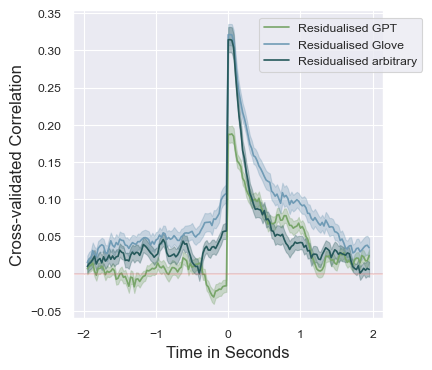

In [68]:
# get model names
models = [k.split(sep='_')[1] for k in results.keys()]
labels = ['Residualised ' + m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(res_results.keys()):
    ax1.plot(times_100, res_results[key].mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(res_results[key])), 
                                upperCI(reshape(res_results[key])), color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.6,0.8))
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+':' + vectors)

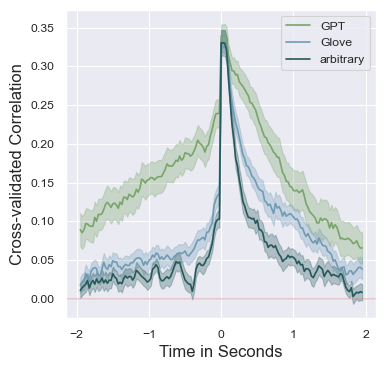

In [69]:
# get model names
models = [k.split(sep='_')[1] for k in res_results.keys()]
labels = [m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(results.keys()):
    ax1.plot(times_100, results[key].mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(results[key])), 
                                upperCI(reshape(results[key])), color=colours[models[i]], alpha=0.3)

ax1.legend()
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+':' + vectors)

### Histogram of the difference in values when encoding from residualised vs. original vectors

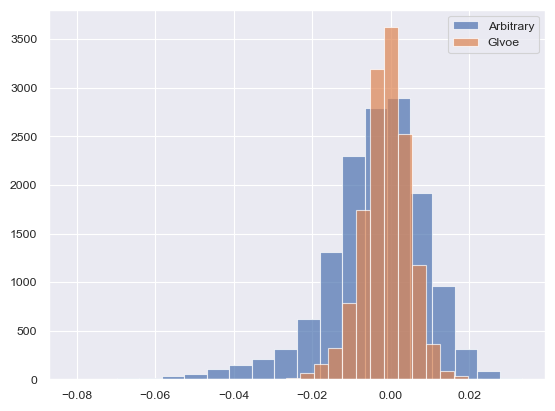

In [ ]:
diff = encoding_arbitrary_residualised - encoding_arbitrary
diff.flatten().shape
plt.hist(diff.flatten(), bins=20, alpha=0.7, label='Arbitrary')
diff = encoding_Glove_residualised - encoding_Glove
diff.flatten().shape
plt.hist(diff.flatten(), bins=20, alpha=0.7, label='Glvoe')
plt.legend()

### Arbitrary encoding: Residualised vs. Orignial vectors

Text(0.5, 1.0, 'Goldstein: arbitrary')

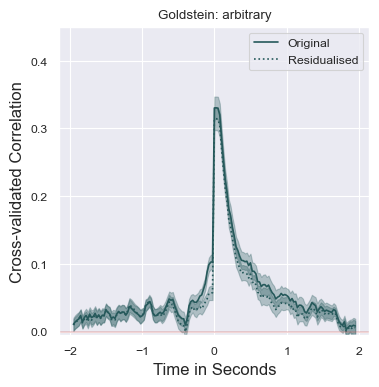

In [70]:
# get model names
models = ['arbitrary', 'arbitrary']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_arbitrary, encoding_arbitrary_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

### GloVe encoding: Residualised vs. Original Vectors 

Text(0.5, 1.0, 'Goldstein: Glove')

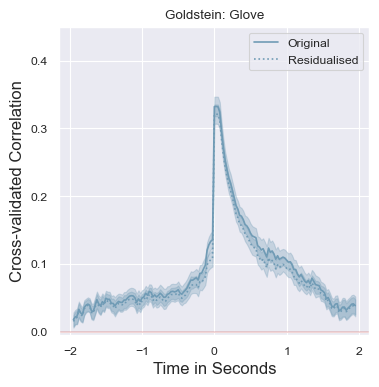

In [71]:
# get model names
models = ['Glove', 'Glove']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove, encoding_Glove_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

Text(0.5, 1.0, 'Goldstein: GPT')

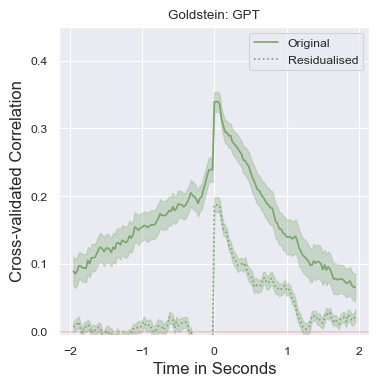

In [72]:
# get model names
models = ['GPT', 'GPT']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_GPT, encoding_GPT_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

## Difference of Predictability on encoding 

In [13]:
import pandas as pd

In [73]:
df = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                            sep='\t',
                            index_col='Unnamed: 0')
# first we only want to keep the word-initial token of a word:
mask_first = df["word_idx"] != df["word_idx"].shift(1)
df_first   = df[mask_first]

is_top_1     = [x < 1 for x in df_first['rank']] # rank 0 is the Top-1 prediction
is_not_top_1 = [not x for x in is_top_1]
is_top_5     = [x < 5 for x in df_first['rank']] # rank 4 is the Top-5 prediction
is_not_top_5 = [not x for x in is_top_5]

print(np.unique(is_top_1, return_counts=True))
print(np.unique(is_top_5, return_counts=True))

(array([False,  True]), array([3651, 1485]))
(array([False,  True]), array([2532, 2604]))


In [39]:
# group by word_idx
groups = df.groupby("word_idx")

# condition: for each word_idx, check if ALL ranks are 0
mask_all_zero = groups["rank"].transform(lambda x: (x == 0).all())
mask_all_less_5 = groups["rank"].transform(lambda x: (x < 5).all())

In [40]:
len(mask_all_zero[mask_first])
np.unique(mask_all_zero[mask_first], return_counts=True), np.unique(mask_all_less_5[mask_first], return_counts=True)

((array([False,  True]), array([3662, 1474])),
 (array([False,  True]), array([2544, 2592])))

This means we have 1485 trials in which the word-initial token is the Top-1 predictions and 2604 trials for which it is among the Top-5 predictions

In [74]:
y_acoustics.shape, X_Glove_residualised.shape, len(is_top_1)

((5136, 157, 9), (5135, 300), 5136)

### First for the original vectors:

In [75]:
y = y_acoustics

X_Glove_top_1     = X_Glove[is_top_1]
X_Glove_top_5     = X_Glove[is_top_5]
X_Glove_not_top_1 = X_Glove[is_not_top_1]
X_Glove_not_top_5 = X_Glove[is_not_top_5]

y_top_1     = y[is_top_1]
y_top_5     = y[is_top_5]
y_not_top_1 = y[is_not_top_1]
y_not_top_5 = y[is_not_top_5]

y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

In [76]:
# compute the encoding of the acoustics for each split
encoding_Glove_top_1     = brainscore_no_coef(X_Glove_top_1, y_top_1)
encoding_Glove_top_5     = brainscore_no_coef(X_Glove_top_5, y_top_5)
encoding_Glove_not_top_1 = brainscore_no_coef(X_Glove_not_top_1, y_not_top_1)
encoding_Glove_not_top_5 = brainscore_no_coef(X_Glove_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 1485, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2604, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3651, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2532, 157)


### and now for the residualised ones:

In [77]:
# Since we are working with residualised vectors, which is not defined for the first word, we need to drop that for our is_top_ masks
y = y_acoustics[1:]

is_top_1     = is_top_1[1:]
is_top_5     = is_top_5[1:]
is_not_top_1 = is_not_top_1[1:]
is_not_top_5 = is_not_top_5[1:]

len(is_top_1), len(is_top_5), len(is_not_top_1), len(is_not_top_5), y.shape

(5135, 5135, 5135, 5135, (5135, 157, 9))

In [78]:
y_top_1     = y[is_top_1]
y_top_5     = y[is_top_5]
y_not_top_1 = y[is_not_top_1]
y_not_top_5 = y[is_not_top_5]

X_Glove_residualised_top_1     = X_Glove_residualised[is_top_1]
X_Glove_residualised_top_5     = X_Glove_residualised[is_top_5]
X_Glove_residualised_not_top_1 = X_Glove_residualised[is_not_top_1]
X_Glove_residualised_not_top_5 = X_Glove_residualised[is_not_top_5]

y_top_1.shape, X_Glove_residualised_top_1.shape

((1485, 157, 9), (1485, 300))

In [79]:
y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

In [80]:
# compute the encoding of the acoustics for each split
encoding_Glove_residualised_top_1     = brainscore_no_coef(X_Glove_residualised_top_1, y_top_1)
encoding_Glove_residualised_top_5     = brainscore_no_coef(X_Glove_residualised_top_5, y_top_5)
encoding_Glove_residualised_not_top_1 = brainscore_no_coef(X_Glove_residualised_not_top_1, y_not_top_1)
encoding_Glove_residualised_not_top_5 = brainscore_no_coef(X_Glove_residualised_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 1485, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2604, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3650, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2531, 157)


Text(0.5, 1.0, 'Goldstein Audio Encoding from Residual Vectors: Top 1')

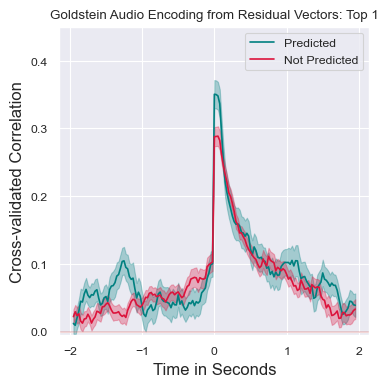

In [81]:
# get model names
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_1, encoding_Glove_residualised_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding from Residual Vectors: ' + models[0])

Text(0.5, 1.0, 'Goldstein Audio Encoding: Original Vectors Top 1')

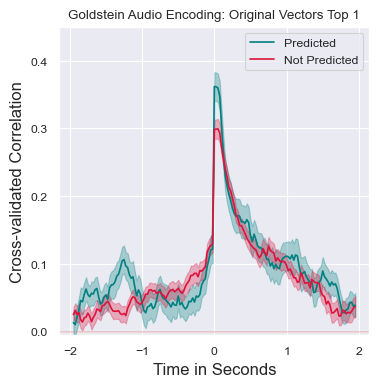

In [82]:
# get model names
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Goldstein Audio Encoding: Top 5')

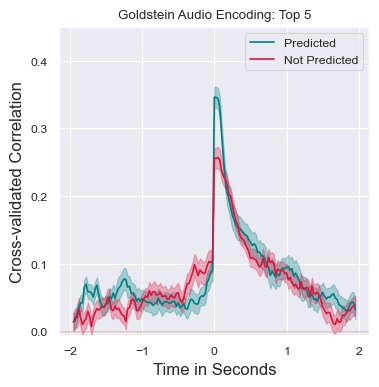

In [83]:
# get model names
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_5, encoding_Glove_residualised_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: ' + models[0])